## Analyse `.json` output from nextclade

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 100

In [2]:
savefigs = True
output_dir = "../figs/nextclade"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Load `.gff`

For this to run, you need to download the sars-cov-2 `.gff` file from ncbi, available from the following link:

source: https://www.ncbi.nlm.nih.gov/sars-cov-2/

In [3]:
ls ../data/resources/

GCF_009858895.2_ASM985889v3_genomic.gff
GCF_009858895.2_ASM985889v3_genomic.gff.gz


In [4]:
gff_fn = "GCF_009858895.2_ASM985889v3_genomic.gff"
gff_path = os.path.join("../data/resources", gff_fn)

rows_to_skip = [i for i, l in enumerate(open(gff_path, "r")) if l.startswith("#")]
gff_df = pd.read_csv(gff_path, 
                     sep="\t",
                     header=None,
                     names=["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"],
                     skiprows=rows_to_skip)

In [5]:
gff_df

,seqname,source,feature,start,end,score,strand,frame,attribute
0,NC_045512.2,RefSeq,region,1,29903,.,+,.,ID=NC_045512.2:1..29903;Dbxref=taxon:2697049;c...
1,NC_045512.2,RefSeq,five_prime_UTR,1,265,.,+,.,ID=id-NC_045512.2:1..265;gbkey=5'UTR
2,NC_045512.2,RefSeq,gene,266,21555,.,+,.,ID=gene-GU280_gp01;Dbxref=GeneID:43740578;Name...
3,NC_045512.2,RefSeq,CDS,266,13468,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...
4,NC_045512.2,RefSeq,CDS,13468,21555,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...
5,NC_045512.2,RefSeq,mature_protein_region_of_CDS,266,805,.,+,.,ID=id-YP_009724389.1:1..180;Note=nsp1%3B produ...
6,NC_045512.2,RefSeq,mature_protein_region_of_CDS,806,2719,.,+,.,ID=id-YP_009724389.1:181..818;Note=produced by...
7,NC_045512.2,RefSeq,mature_protein_region_of_CDS,2720,8554,.,+,.,ID=id-YP_009724389.1:819..2763;Note=former nsp...
8,NC_045512.2,RefSeq,mature_protein_region_of_CDS,8555,10054,.,+,.,ID=id-YP_009724389.1:2764..3263;Note=nsp4B_TM%...
9,NC_045512.2,RefSeq,mature_protein_region_of_CDS,10055,10972,.,+,.,ID=id-YP_009724389.1:3264..3569;Note=nsp5A_3CL...


In [6]:
gene_df = gff_df.query("feature == 'gene'")
gene_df.insert(5, "gene_name", [line.split("=")[1]
                                for row in gene_df["attribute"]
                                for line in row.split(";")
                                if "Name" in line ])
gene_df.insert(5, "length", gene_df["end"] - gene_df["start"] + 1)
gene_df.index=gene_df["gene_name"]

In [7]:
gene_df

,seqname,source,feature,start,end,length,gene_name,score,strand,frame,attribute
gene_name,,,,,,,,,,,
ORF1ab,NC_045512.2,RefSeq,gene,266,21555,21290,ORF1ab,.,+,.,ID=gene-GU280_gp01;Dbxref=GeneID:43740578;Name...
S,NC_045512.2,RefSeq,gene,21563,25384,3822,S,.,+,.,ID=gene-GU280_gp02;Dbxref=GeneID:43740568;Name...
ORF3a,NC_045512.2,RefSeq,gene,25393,26220,828,ORF3a,.,+,.,ID=gene-GU280_gp03;Dbxref=GeneID:43740569;Name...
E,NC_045512.2,RefSeq,gene,26245,26472,228,E,.,+,.,ID=gene-GU280_gp04;Dbxref=GeneID:43740570;Name...
M,NC_045512.2,RefSeq,gene,26523,27191,669,M,.,+,.,ID=gene-GU280_gp05;Dbxref=GeneID:43740571;Name...
ORF6,NC_045512.2,RefSeq,gene,27202,27387,186,ORF6,.,+,.,ID=gene-GU280_gp06;Dbxref=GeneID:43740572;Name...
ORF7a,NC_045512.2,RefSeq,gene,27394,27759,366,ORF7a,.,+,.,ID=gene-GU280_gp07;Dbxref=GeneID:43740573;Name...
ORF7b,NC_045512.2,RefSeq,gene,27756,27887,132,ORF7b,.,+,.,ID=gene-GU280_gp08;Dbxref=GeneID:43740574;Name...
ORF8,NC_045512.2,RefSeq,gene,27894,28259,366,ORF8,.,+,.,ID=gene-GU280_gp09;Dbxref=GeneID:43740577;Name...


In [8]:
col_dt = dict(zip(gene_df["gene_name"], sns.color_palette("viridis", gene_df.shape[0])))

Text(0.0, 1.0, 'SARS-CoV-2 Genome')

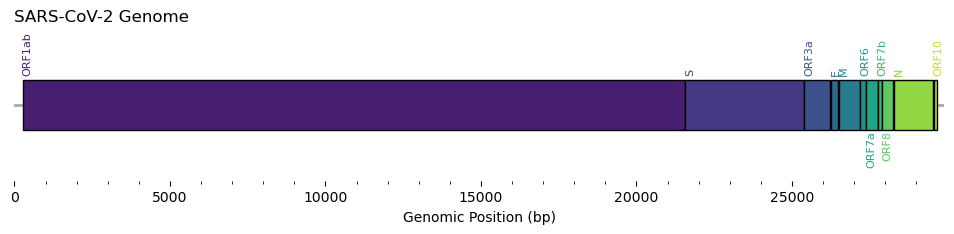

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

y = 0
h = 10

genome_start, genome_end = (0, gff_df.loc[0]["end"])
ax.plot([genome_start, genome_end], [y+h/2]*2, lw=2, c="darkgrey", zorder=-2)


for gene, row in gene_df.iterrows():
    # Boxes
    r = patches.Rectangle((row["start"], y), row["length"], h,
                          linewidth=1, edgecolor='black', facecolor=col_dt[gene])
    ax.add_patch(r)
    
    # Genes Names
    if row["gene_name"] not in ["ORF7a", "ORF8"]:
        ax.annotate(xy=(row["start"],y+h+1), xycoords="data", 
                    ha="left", va="bottom", rotation=90, fontsize=8,
                    text=row["gene_name"], c=col_dt[gene])
    else:
        ax.annotate(xy=(row["start"],y), xycoords="data", 
                    ha="left", va="top", rotation=90, fontsize=8,
                    text=row["gene_name"], c=col_dt[gene])

# Limits
xlims = (0, gff_df.loc[0]["end"])
ax.set_xlim(xlims)   
ax.set_ylim(y-h, 2*h)
        
# Ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(10**3))
ax.xaxis.set_major_locator(plt.MultipleLocator(5*10**3))

# Clean up axis
for s in ["top", "bottom", "left", "right"]:
    ax.spines[s].set_visible(False)
ax.set_yticks([])

# Labels
ax.set_xlabel("Genomic Position (bp)")
ax.set_title("SARS-CoV-2 Genome", loc="left")

## Load nextclade results

In [10]:
ls ../data/nextclade/

nextclade.json


In [11]:
dt = json.load(open("../data/nextclade/nextclade.json", "r"))

In [12]:
len(dt)

285

In [13]:
aa_dt = {
    "positive" : ["R", "H", "K"],
    "negative" : ["D", "E"],
    "uncharged" : ["S", "T", "N", "Q"],
    "special" : ["C", "U", "G", "P"],
    "hydrophobic" : ["A", "I", "L", "M", "F", "W", "Y", "V"],
    "deletion" : ["*"]
}

In [14]:
aa_map = {}
for k, vs in aa_dt.items():
    for v in vs:
        aa_map[v] = k

In [15]:
results_dt = {
    "seqName": [],
    "clade": [],
    "pos": [],
    "refNuc": [],
    "queryNuc": [],
    "gene": [],
    "codon": [],
    "refAA": [],
    "queryAA": [],
    "refCodon": [],
    "queryCodon": [],
    "refAA_prop": [],
    "queryAA_prop": []
}


for i, sample in enumerate(dt):
    if "substitutions" in sample.keys():
        for substitution in sample["substitutions"]:
            aa_substitutions = substitution["aaSubstitutions"]
            if len(aa_substitutions) > 0:
                for aa_substitution in aa_substitutions:
                    # Extract sequence information
                    results_dt["seqName"].append(sample["seqName"])
                    results_dt["clade"].append(sample["clade"])

                    # Extract nucleotide information
                    for m in ["pos", "refNuc", "queryNuc"]:
                        results_dt[m].append(substitution[m])

                    # Extract amino acid information
                    for m in ["gene", "codon", "refAA", "queryAA", "refCodon", "queryCodon"]:
                        results_dt[m].append(aa_substitution[m])
                        
                    # AA properties
                    results_dt["refAA_prop"].append(aa_map[aa_substitution["refAA"]])
                    results_dt["queryAA_prop"].append(aa_map[aa_substitution["queryAA"]])
    else:
        print("Failed for %s" % sample["seqName"])

Failed for NTC/ARTIC/nanopolish MN908947.3 (3)
Failed for 128_LoCost/ARTIC/nanopolish MN908947.3
Failed for NTC/ARTIC/nanopolish MN908947.3 (4)


In [16]:
df = pd.DataFrame(results_dt)

In [17]:
# Let's add some identifier columns for mutations
df.insert(5, "nt_change", ["%s%d%s" % (row["refNuc"], row["pos"], row["queryNuc"]) for i, row in df.iterrows()])
df.insert(10, "aa_change", ["%s%d%s" % (row["refAA"], row["codon"], row["queryAA"]) for i, row in df.iterrows()])

In [18]:
df.head()

,seqName,clade,pos,refNuc,queryNuc,nt_change,gene,codon,refAA,queryAA,aa_change,refCodon,queryCodon,refAA_prop,queryAA_prop
0,20131/ARTIC/nanopolish MN908947.3,20B,5699,C,A,C5699A,ORF1a,1811,A,D,A1811D,GCT,GAT,hydrophobic,negative
1,20131/ARTIC/nanopolish MN908947.3,20B,10539,G,T,G10539T,ORF1a,3424,M,I,M3424I,ATG,ATT,hydrophobic,hydrophobic
2,20131/ARTIC/nanopolish MN908947.3,20B,14407,C,T,C14407T,ORF1b,313,P,L,P313L,CCT,CTT,special,hydrophobic
3,20131/ARTIC/nanopolish MN908947.3,20B,23402,A,G,A23402G,S,613,D,G,D613G,GAT,GGT,negative,special
4,20131/ARTIC/nanopolish MN908947.3,20B,28880,G,A,G28880A,N,202,R,K,R202K,AGG,AAA,positive,positive


## Heatmap of amino acid changes

In [19]:
aa_cross = pd.crosstab([df["refAA_prop"], df["refAA"]], 
                       [df["queryAA_prop"], df["queryAA"]])

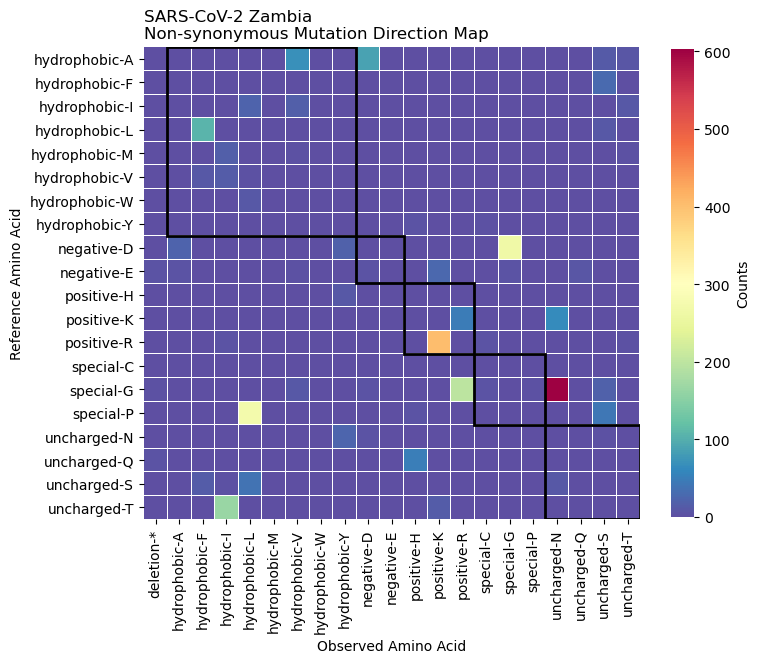

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# Plot
sns.heatmap(aa_cross,
            cmap="Spectral_r",
            linewidths=0.01,
            square=True,
            cbar_kws={"label": "Counts", "shrink": 0.775},
            ax = ax)

# Labels
ax.set_title("SARS-CoV-2 Zambia\nNon-synonymous Mutation Direction Map", loc="left")
ax.set_xlabel("Observed Amino Acid")
ax.set_ylabel("Reference Amino Acid")

# Rectangles
order = ["hydrophobic", "negative", "positive", "special", "uncharged"]
c = 0
for k in order:
    w, h = aa_cross.loc[k, k].shape
    r = patches.Rectangle((c+1, c), w, h,
                          linewidth=2, edgecolor='black', facecolor='none')
    c += w
    ax.add_patch(r)

if savefigs:
    fig.savefig(os.path.join(output_dir, "2021-01-14_sars-aa-confusion.png"),
                pad_inches=0.5, bbox_inches="tight")

## Number of mutations by sample

In [21]:
muts_per_sample = (df
                   .groupby(["seqName", "clade"])
                   .size()
                   .reset_index()
                  )
muts_per_sample.columns = ["seqName", "clade", "counts"]

In [22]:
muts_per_sample

,seqName,clade,counts
0,111/ARTIC/nanopolish MN908947.3,19A,5
1,111CleanLoCost/ARTIC/nanopolish MN908947.3,19A,4
2,111CleanStd/ARTIC/nanopolish MN908947.3,19A,4
3,1241/ARTIC/nanopolish MN908947.3,19B,5
4,125/ARTIC/nanopolish MN908947.3,20B,9
...,...,...,...
268,NTC/ARTIC/nanopolish MN908947.3 (2),20B,1
269,V65109/ARTIC/nanopolish MN908947.3,20H/501Y.V2,23
270,V65182/ARTIC/nanopolish MN908947.3,20H/501Y.V2,22
271,V65185/ARTIC/nanopolish MN908947.3,20H/501Y.V2,20


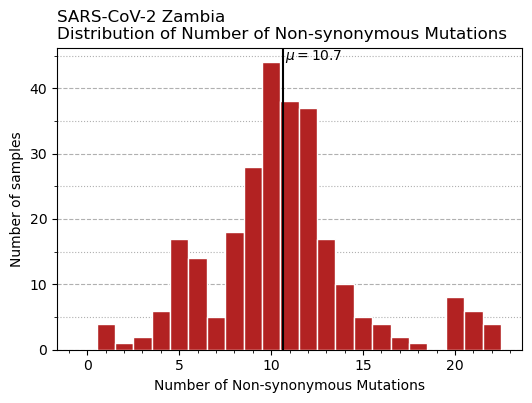

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot
ax.hist(muts_per_sample["counts"], 
        bins=np.arange(0, muts_per_sample["counts"].max()+1, 1) - 1/2,  # center bins on integer
        lw=1, ec="white", color="firebrick", zorder=10)


# Indicators
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax.grid(axis="y", which='minor', ls='dotted', zorder=-1)
ax.grid(axis="y", which='major', ls='dashed', zorder=-1)

mu = muts_per_sample["counts"].mean()
ax.axvline(mu, color="black", zorder=12)
ax.annotate(xy=(mu*1.01, ax.get_ylim()[1]), xycoords="data", ha="left", va="top",
            text="$\mu=$%.01f" % mu)


# Label
ax.set_title("SARS-CoV-2 Zambia\nDistribution of Number of Non-synonymous Mutations", loc="left")
ax.set_xlabel("Number of Non-synonymous Mutations")
ax.set_ylabel("Number of samples")

if savefigs:
    fig.savefig(os.path.join(output_dir, "2021-01-26_sars-mutation-counts.png"),
                dpi=300, pad_inches=0.5, bbox_inches="tight")

### Partition by clade

In [24]:
clades = muts_per_sample["clade"].unique()
clade_dt = dict(zip(clades, sns.color_palette("inferno_r")))

In [25]:
clade_dt

{'19A': (0.981173, 0.759135, 0.156863),
 '19B': (0.961293, 0.488716, 0.084289),
 '20B': (0.832299, 0.283913, 0.257383),
 '20A': (0.621685, 0.164184, 0.388781),
 '20D': (0.397674, 0.083257, 0.433183),
 '20H/501Y.V2': (0.15585, 0.044559, 0.325338)}

In [26]:
muts_per_sample.shape[0]

273

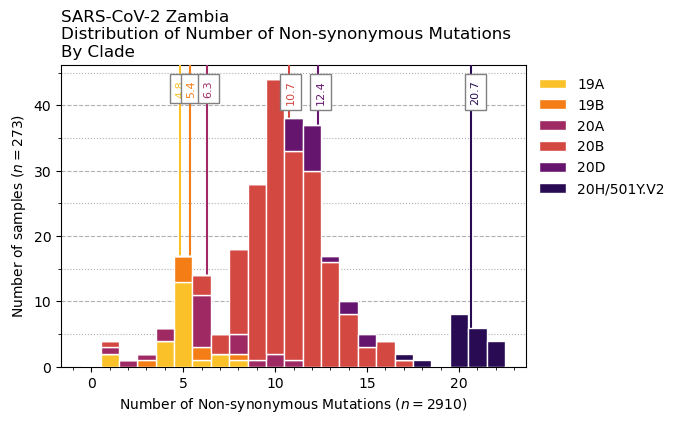

In [27]:
fig, ax = plt.subplots(1, 1)

grps = muts_per_sample.groupby("clade")
ax.hist([df["counts"] for clade, df in grps], 
        bins=np.arange(0, muts_per_sample["counts"].max()+1, 1) - 1/2,  # center bins on integer
        stacked=True,
        lw=1, ec="white", color=[clade_dt[c] for c, _ in grps],
        label=[c for c,_ in grps],
        zorder=10)

# Indicators
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax.grid(axis="y", which='minor', ls='dotted', zorder=-1)
ax.grid(axis="y", which='major', ls='dashed', zorder=-1)

# Lines for all strains
for c, cdf in grps:
    mu = cdf["counts"].mean()
    ax.axvline(mu, color=clade_dt[c], zorder=8)
    ax.annotate(xy=(mu*1.01, ax.get_ylim()[1]*0.95), xycoords="data", 
                c=clade_dt[c], zorder=10, fontsize=8,
                bbox=dict(facecolor='white', edgecolor='grey'),
                ha="center", va="top", rotation=90,
                text="%.01f" % mu)
    


# Label
ax.set_title("SARS-CoV-2 Zambia\nDistribution of Number of Non-synonymous Mutations\nBy Clade", loc="left")
ax.set_xlabel("Number of Non-synonymous Mutations ($n=$%d)" % muts_per_sample["counts"].sum())
ax.set_ylabel("Number of samples ($n=$%d)" % muts_per_sample.shape[0])
ax.legend(bbox_to_anchor=(1, 1), frameon=False)

if savefigs:
    fig.savefig(os.path.join(output_dir, "2021-01-26_sars-mutation-counts-by-clade.png"),
                dpi=300, pad_inches=0.5, bbox_inches="tight")

### Partition by gene

In [28]:
df.head()

,seqName,clade,pos,refNuc,queryNuc,nt_change,gene,codon,refAA,queryAA,aa_change,refCodon,queryCodon,refAA_prop,queryAA_prop
0,20131/ARTIC/nanopolish MN908947.3,20B,5699,C,A,C5699A,ORF1a,1811,A,D,A1811D,GCT,GAT,hydrophobic,negative
1,20131/ARTIC/nanopolish MN908947.3,20B,10539,G,T,G10539T,ORF1a,3424,M,I,M3424I,ATG,ATT,hydrophobic,hydrophobic
2,20131/ARTIC/nanopolish MN908947.3,20B,14407,C,T,C14407T,ORF1b,313,P,L,P313L,CCT,CTT,special,hydrophobic
3,20131/ARTIC/nanopolish MN908947.3,20B,23402,A,G,A23402G,S,613,D,G,D613G,GAT,GGT,negative,special
4,20131/ARTIC/nanopolish MN908947.3,20B,28880,G,A,G28880A,N,202,R,K,R202K,AGG,AAA,positive,positive


In [29]:
muts_by_gene_df = (df
                   .groupby(["gene"])
                   .agg(
                       total_muts=pd.NamedAgg("gene", len),
                       unique_muts=pd.NamedAgg("nt_change", lambda x: len(set(x)))
                   )
                   .reset_index()
                  )
muts_by_gene_df

,gene,total_muts,unique_muts
0,E,23,2
1,M,6,4
2,N,712,30
3,ORF10,31,3
4,ORF14,647,12
5,ORF1a,437,107
6,ORF1b,399,57
7,ORF3a,121,21
8,ORF6,2,2
9,ORF7a,25,6


In [30]:
merge_df = gene_df.drop(["gene_name", "seqname", 
                         "source", "feature", "score", 
                         "strand", "frame", "attribute"], 
                        axis=1, inplace=False)
merge_df.reset_index(inplace=True)

In [31]:
to_add = {
    "gene_name": ["ORF1a", "ORF1b"],
    "start": [266, 13468],
    "end": [13468, 21555],
    "length": [13468-266, 21555-13468]
}

In [32]:
merge_df = merge_df.append(pd.DataFrame(to_add))

In [33]:
# Not the cleanest
gdf = pd.merge(muts_by_gene_df, merge_df, how="left", left_on="gene", right_on="gene_name")
gdf.insert(3, "unique_muts_norm", gdf["unique_muts"]/gdf["length"])
gdf.sort_values("start", inplace=True)
gdf.index = gdf["gene"]

In [34]:
gdf

,gene,total_muts,unique_muts,unique_muts_norm,gene_name,start,end,length
gene,,,,,,,,
ORF1a,ORF1a,437,107,0.008105,ORF1a,266.0,13468.0,13202.0
ORF1b,ORF1b,399,57,0.007048,ORF1b,13468.0,21555.0,8087.0
S,S,407,32,0.008373,S,21563.0,25384.0,3822.0
ORF3a,ORF3a,121,21,0.025362,ORF3a,25393.0,26220.0,828.0
E,E,23,2,0.008772,E,26245.0,26472.0,228.0
M,M,6,4,0.005979,M,26523.0,27191.0,669.0
ORF6,ORF6,2,2,0.010753,ORF6,27202.0,27387.0,186.0
ORF7a,ORF7a,25,6,0.016393,ORF7a,27394.0,27759.0,366.0
ORF7b,ORF7b,3,2,0.015152,ORF7b,27756.0,27887.0,132.0


In [35]:
col_dt.update({"ORF1a": col_dt["ORF1ab"],
               "ORF1b": col_dt["ORF1ab"],
               "ORF14": "darkgrey",
               "ORF9b": "darkgrey"
              })

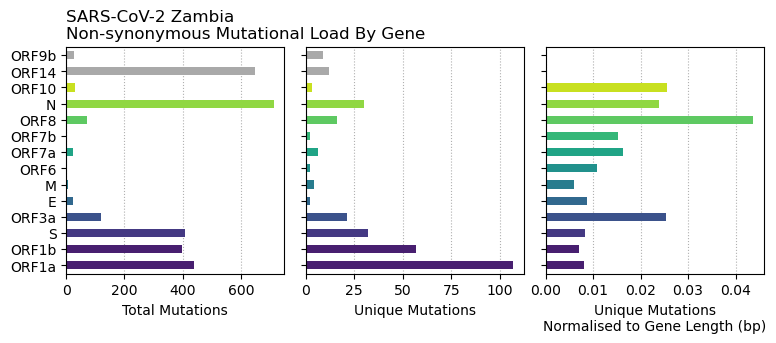

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
fig.subplots_adjust(wspace=0.1)

# Total
gdf["total_muts"].plot.barh(ax=ax[0], 
                            color=[col_dt[g] for g in gdf["gene"]], zorder=2)
ax[0].set_ylabel("")
ax[0].set_xlabel("Total Mutations")
ax[0].set_title("SARS-CoV-2 Zambia\nNon-synonymous Mutational Load By Gene", loc="left")
ax[0].grid(axis='x', ls='dotted', zorder=-20)

# Unique
gdf["unique_muts"].plot.barh(ax=ax[1],
                             color=[col_dt[g] for g in gdf["gene"]], zorder=2)
ax[1].set_xlabel("Unique Mutations")
ax[1].grid(axis='x', ls='dotted', zorder=-20)

# Normalised
gdf["unique_muts_norm"].plot.barh(ax=ax[2],
                                  color=[col_dt[g] for g in gdf["gene"]], zorder=2)
ax[2].set_xlabel("Unique Mutations\nNormalised to Gene Length (bp)")
ax[2].grid(axis='x', ls='dotted', zorder=-20)

if savefigs:
    fig.savefig(os.path.join(output_dir, "2021-01-26_sars-by-gene.png"),
                dpi=300, pad_inches=0.5, bbox_inches="tight")

- For some reason, ORF9b and ORF14 are not in the `.gff`, but are present in nextclade outputs
- For now just colour grey, and can't include in rightmost panel

## Mutation counts along genome

In [37]:
gene_df

,seqname,source,feature,start,end,length,gene_name,score,strand,frame,attribute
gene_name,,,,,,,,,,,
ORF1ab,NC_045512.2,RefSeq,gene,266,21555,21290,ORF1ab,.,+,.,ID=gene-GU280_gp01;Dbxref=GeneID:43740578;Name...
S,NC_045512.2,RefSeq,gene,21563,25384,3822,S,.,+,.,ID=gene-GU280_gp02;Dbxref=GeneID:43740568;Name...
ORF3a,NC_045512.2,RefSeq,gene,25393,26220,828,ORF3a,.,+,.,ID=gene-GU280_gp03;Dbxref=GeneID:43740569;Name...
E,NC_045512.2,RefSeq,gene,26245,26472,228,E,.,+,.,ID=gene-GU280_gp04;Dbxref=GeneID:43740570;Name...
M,NC_045512.2,RefSeq,gene,26523,27191,669,M,.,+,.,ID=gene-GU280_gp05;Dbxref=GeneID:43740571;Name...
ORF6,NC_045512.2,RefSeq,gene,27202,27387,186,ORF6,.,+,.,ID=gene-GU280_gp06;Dbxref=GeneID:43740572;Name...
ORF7a,NC_045512.2,RefSeq,gene,27394,27759,366,ORF7a,.,+,.,ID=gene-GU280_gp07;Dbxref=GeneID:43740573;Name...
ORF7b,NC_045512.2,RefSeq,gene,27756,27887,132,ORF7b,.,+,.,ID=gene-GU280_gp08;Dbxref=GeneID:43740574;Name...
ORF8,NC_045512.2,RefSeq,gene,27894,28259,366,ORF8,.,+,.,ID=gene-GU280_gp09;Dbxref=GeneID:43740577;Name...


In [38]:
gene_dt = { row["gene_name"]: (row["start"], row["end"]) for g, row in gene_df.iterrows() }
gene_dt

{'ORF1ab': (266, 21555),
 'S': (21563, 25384),
 'ORF3a': (25393, 26220),
 'E': (26245, 26472),
 'M': (26523, 27191),
 'ORF6': (27202, 27387),
 'ORF7a': (27394, 27759),
 'ORF7b': (27756, 27887),
 'ORF8': (27894, 28259),
 'N': (28274, 29533),
 'ORF10': (29558, 29674)}

In [39]:
c = Counter(df.groupby(["pos", "queryNuc"]).size().reset_index()["pos"])

In [40]:
def get_gene(x):
    """ Get gene name given position """
    l = "None"
    for g, i in gene_dt.items():
        if i[0] <= x <= i[1]:
            l = g
    return l

In [41]:
df

,seqName,clade,pos,refNuc,queryNuc,nt_change,gene,codon,refAA,queryAA,aa_change,refCodon,queryCodon,refAA_prop,queryAA_prop
0,20131/ARTIC/nanopolish MN908947.3,20B,5699,C,A,C5699A,ORF1a,1811,A,D,A1811D,GCT,GAT,hydrophobic,negative
1,20131/ARTIC/nanopolish MN908947.3,20B,10539,G,T,G10539T,ORF1a,3424,M,I,M3424I,ATG,ATT,hydrophobic,hydrophobic
2,20131/ARTIC/nanopolish MN908947.3,20B,14407,C,T,C14407T,ORF1b,313,P,L,P313L,CCT,CTT,special,hydrophobic
3,20131/ARTIC/nanopolish MN908947.3,20B,23402,A,G,A23402G,S,613,D,G,D613G,GAT,GGT,negative,special
4,20131/ARTIC/nanopolish MN908947.3,20B,28880,G,A,G28880A,N,202,R,K,R202K,AGG,AAA,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,37049/ARTIC/nanopolish MN908947.3,20B,28880,G,A,G28880A,ORF14,49,G,N,G49N,GGG,AAC,special,uncharged
2906,37049/ARTIC/nanopolish MN908947.3,20B,28881,G,A,G28881A,N,202,R,K,R202K,AGG,AAA,positive,positive
2907,37049/ARTIC/nanopolish MN908947.3,20B,28881,G,A,G28881A,ORF14,49,G,N,G49N,GGG,AAC,special,uncharged
2908,37049/ARTIC/nanopolish MN908947.3,20B,28882,G,C,G28882C,N,203,G,R,G203R,GGA,CGA,special,positive


In [42]:
pos_df = (df
          .groupby(["pos", "aa_change"])
          .agg(
              count=pd.NamedAgg("pos", len)
          )
          .reset_index()
          .sort_values("pos")
         )
pos_df.insert(2, "gene_name", [get_gene(x) for x in pos_df["pos"]])
pos_df

,pos,aa_change,gene_name,count
0,361,D32Y,ORF1ab,3
1,404,K46R,ORF1ab,1
2,525,E86D,ORF1ab,2
3,598,G111S,ORF1ab,1
4,674,G136A,ORF1ab,2
...,...,...,...,...
299,29424,Q383H,N,14
300,29499,Q408H,N,3
301,29641,Q28*,ORF10,1
302,29644,V29L,ORF10,1


In [43]:
pos_df.query("aa_change == 'G49N'")

,pos,aa_change,gene_name,count
273,28880,G49N,N,201
275,28881,G49N,N,201
279,28882,G49N,N,201


- Not exactly sure how the records are stored here
- Looks like this is a single 3-nucleotide mutation, from `GGG` to `AAC`
- The plot will actually work out correctly anyways

In [44]:
def plot_covid_genome(gene_df, gff_df, y, h, ax):
    """ Plot the SARS Genome """
    
    genome_start, genome_end = (0, gff_df.loc[0]["end"])
    ax.plot([genome_start, genome_end], [y+h/2]*2, lw=2, c="darkgrey", zorder=-2)


    for gene, row in gene_df.iterrows():
        # Boxes
        r = patches.Rectangle((row["start"], y), row["length"], h,
                              linewidth=1, edgecolor='black', facecolor=col_dt[gene])
        ax.add_patch(r)

        # Genes Names
        if row["gene_name"] in ["ORF7a", "ORF8"]:
            pass
        else:
            ax.annotate(xy=(row["start"],y), xycoords="data", 
                        ha="left", va="top", rotation=90, fontsize=8,
                        text=row["gene_name"], c=col_dt[gene])

    # Limits
    xlims = (0, gff_df.loc[0]["end"])
    ax.set_xlim(xlims)   
    ax.set_ylim(y-h, 2*h)

    # Clean up axis
    for s in ["top", "bottom", "left", "right"]:
        ax.spines[s].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Make background transparent
    ax.set_facecolor((0, 0, 0, 0))

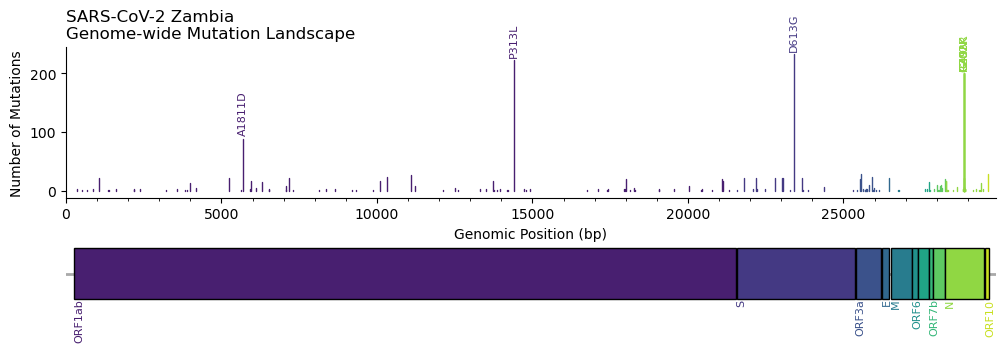

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4), sharex=False)
fig.subplots_adjust(hspace=0)

for x, row in pos_df.iterrows():
    ax[0].arrow(x=row["pos"], y=0,
                dx=0, dy=row["count"],
                lw=1, color=col_dt[row["gene_name"]],
                capstyle="round")
    
    if row["count"] > 50:
        ax[0].annotate(xy=(row["pos"], row["count"]+5),
                       xycoords="data",
                       ha="center", va="bottom", rotation=90,
                       text=row["aa_change"], color=col_dt[row["gene_name"]],
                       fontsize=8)
    

# Limits
xlims = (0, gff_df.loc[0]["end"])
ax[0].set_xlim(xlims)  

# Ticks
ax[0].xaxis.set_minor_locator(plt.MultipleLocator(10**3))
ax[0].xaxis.set_major_locator(plt.MultipleLocator(5*10**3))

# Box
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)

# Labels
ax[0].set_xlabel("Genomic Position (bp)")
ax[0].set_ylabel("Number of Mutations")
ax[0].set_title("SARS-CoV-2 Zambia\nGenome-wide Mutation Landscape", loc="left")

# Covid Plot
plot_covid_genome(gene_df, gff_df, h=10, y=0, ax=ax[1])

if savefigs:
    fig.savefig(os.path.join(output_dir, "2021-01-26_sars-genome.png"),
                pad_inches=0.5, bbox_inches="tight")
    fig.savefig(os.path.join(output_dir, "2021-01-26_sars-genome_dpi500.svg"),
                pad_inches=0.5, dpi=500, bbox_inches="tight")

In [46]:
pos_df.query("gene_name == 'S'")

,pos,aa_change,gene_name,count
164,21574,L4F,S,2
165,21617,T18I,S,1
166,21800,D79A,S,22
167,21845,T94I,S,1
168,21866,R101I,S,1
169,22025,S154I,S,1
170,22087,L175F,S,3
171,22205,D214G,S,22
172,22223,S220L,S,3
173,22298,R245K,S,1


- List of all the mutations observed in `S`
- Worth checking these match expectation for the `501Y.V2` lineage